# Remove Redundant Data

In [1]:
print("test")

test


In [42]:
import pandas as pd

# Reading a CSV file into a DataFrame, selecting specific columns
fields = ['item_description']
df = pd.read_csv('order_details_202505141508.csv', usecols=fields)

# use for loop to print first 10 rows of the DataFrame
for i in range(10):
    print(df.iloc[i])

item_description    Place Packing List Inside Box and Stamp Box
Name: 0, dtype: object
item_description    5 PIECES PER POLYBAG
Name: 1, dtype: object
item_description    Place Packing List Inside Box and Stamp Box
Name: 2, dtype: object
item_description    Place Packing List Inside Box and Stamp Box
Name: 3, dtype: object
item_description    50 EACH OF ITEM COLOR IN ONE BOX
Name: 4, dtype: object
item_description    Place Packing List Inside Box and Stamp Box
Name: 5, dtype: object
item_description    Place Packing List Inside Box and Stamp Box
Name: 6, dtype: object
item_description    Place Packing List Inside Box and Stamp Box
Name: 7, dtype: object
item_description    APPLY BARCODE LABELS TO EACH ITEM
Name: 8, dtype: object
item_description    5 PER POLYBAG
Name: 9, dtype: object


In [ ]:
print(df.shape)
print("\n\nAfter removing duplicates")
df['item_description'] = df['item_description'].str.lower() # there are lots of words with the same meaning but different cases
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)


print(df.head())

# turn it into a list
item_list = df['item_description'].tolist()
print(len(item_list))

(3510, 1)


After removing duplicates
(3510, 1)
(3361, 1)
                              item_description
0  place packing list inside box and stamp box
1                         5 pieces per polybag
4             50 each of item color in one box
8            apply barcode labels to each item
9                                5 per polybag
3361


UMAP is often preferred for larger datasets or when maintaining both global and local patterns is crucial, while t-SNE might be used for finer cluster analysis in smaller datasets. PCA is generally faster and preferred for preliminary analysis or when the relationships in the data are primarily linear.

Try UMAP first

In [57]:
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt

# load the model
model = SentenceTransformer('all-MiniLM-L6-v2')
# encode the sentences
embeddings = model.encode(item_list, show_progress_bar=True)

# reduce the dimensionality of the embeddings. 
# n_neighbors is the number of neighbors to consider when constructing the UMAP graph. For noisy data, larger n_neighbors may produce more stable embeddings.
# n_components is the number of dimensions to reduce to(output dimension). Use 2 for visulization purposes, try 5 later!
reducer = umap.UMAP(n_neighbors=30, n_components=5, metric='cosine')
embeddings = reducer.fit_transform(embeddings)

# clustering the reduced embeddings
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, metric='euclidean') # for min_cluster_size, Smaller → more (and smaller) clusters, Larger → fewer, more robust clusters

# fit the HDBSCAN model to the reduced embeddings
clusterer.fit(embeddings)
# get the cluster labels
labels = clusterer.labels_

Batches:   0%|          | 0/106 [00:00<?, ?it/s]

In [59]:
from collections import defaultdict

# Create a dictionary to hold sentences by cluster
cluster_dict = defaultdict(list)

# Fill the dictionary
for label, sentence in zip(clusterer.labels_, item_list):
    cluster_dict[label].append(sentence)

# Display a few clusters
for label in sorted(cluster_dict.keys()):
    print(f"\n=== Cluster {label} ===")
    for sentence in cluster_dict[label][:10]:  # Show only first 10 per cluster
        print(f"• {sentence}")
    if len(cluster_dict[label]) > 10:
        print(f"...and {len(cluster_dict[label]) - 10} more\n")


=== Cluster -1 ===
• place packing list inside box and stamp box
• 50 each of item color in one box
• place packing list inside box and stamp box	
• yellow msb.com labels to outside of all shipping cartons
• 1 box assorted items
• 140 of each color per box
• 140 of each color per box 2 full boxes
• 120 of each color 1 partial box
• 100 of each color 1 partial box
• package in as few boxes as possible
...and 916 more


=== Cluster 0 ===
• name on bottle should be sara chomack
• xiomara mass
• henry skolnick
• chris tantillo
• tod bowermaster
• jennifer nitchman
• shawn weil
• julia paine
• victoria knudston
• beth guterman chu
...and 61 more


=== Cluster 1 ===
• apply correct ingredients labels
• add ingredient label
• add ingredients label
• apply qr code label for canadian ingredient label
• apply qr code label for canadian ingredient label 
• adhere qr code label for canadian ingredient label
• apply qr code for canadian ingredient label
• adhere qr code to wsa-gm20 for canada ship

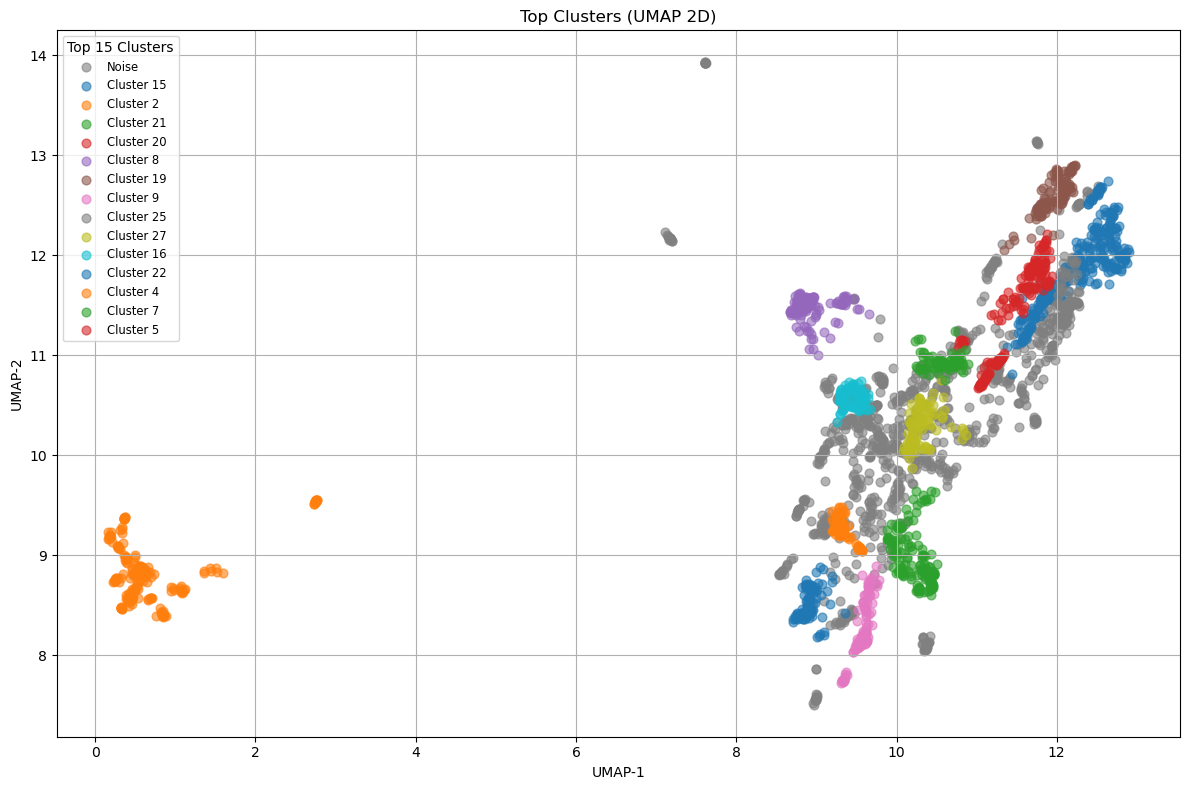

In [58]:
# Optional: create a DataFrame for easier plotting/inspection
df = pd.DataFrame({
    'x': embeddings[:, 0],
    'y': embeddings[:, 1],
    'label': labels,
    'text': item_list
})

# Limit legend to top N most common clusters
N = 15
top_labels = df['label'].value_counts().head(N).index.tolist()

plt.figure(figsize=(12, 8))
for label in top_labels:
    cluster_data = df[df['label'] == label]
    color = 'gray' if label == -1 else None
    plt.scatter(cluster_data['x'], cluster_data['y'],
                label=f'Cluster {label}' if label != -1 else 'Noise',
                alpha=0.6, s=40, c=color)

plt.legend(loc='best', fontsize='small', title=f'Top {N} Clusters')
plt.title('Top Clusters (UMAP 2D)')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.grid(True)
plt.tight_layout()
plt.show()

```
reducer = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine')
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean')
```
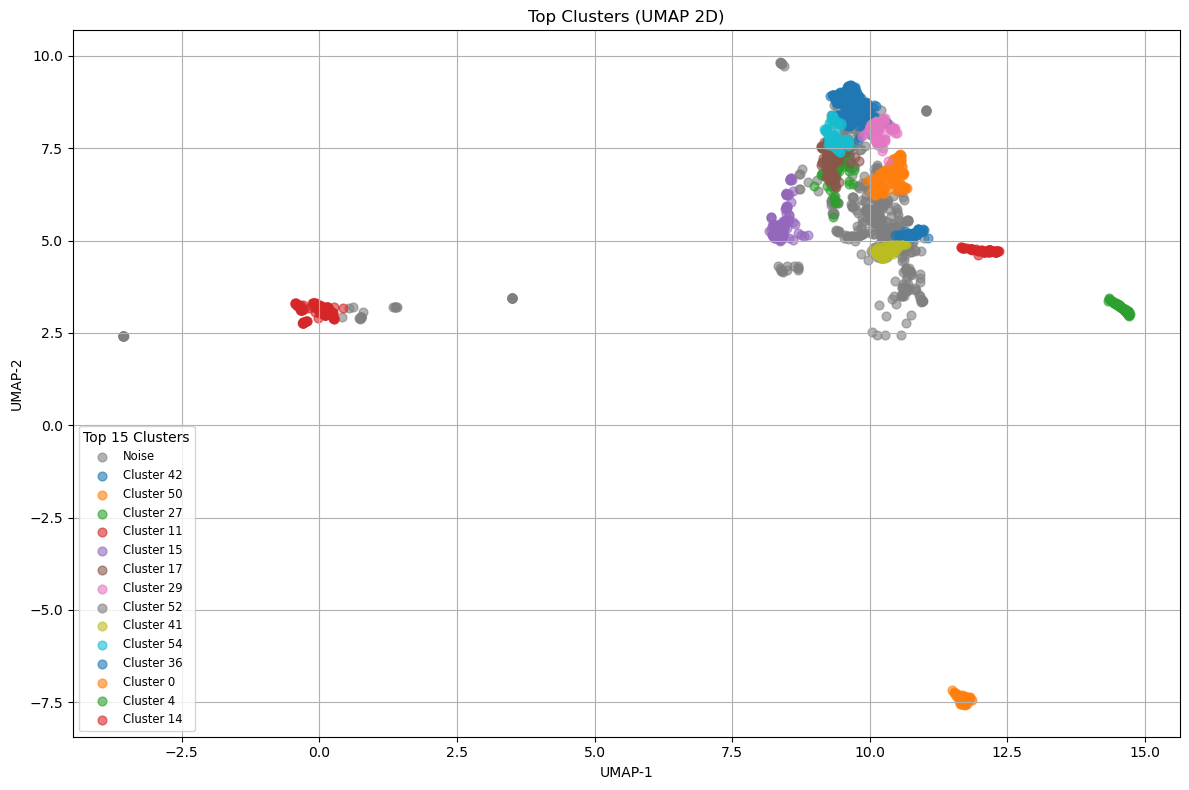

```
reducer = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine')
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, metric='euclidean')
```
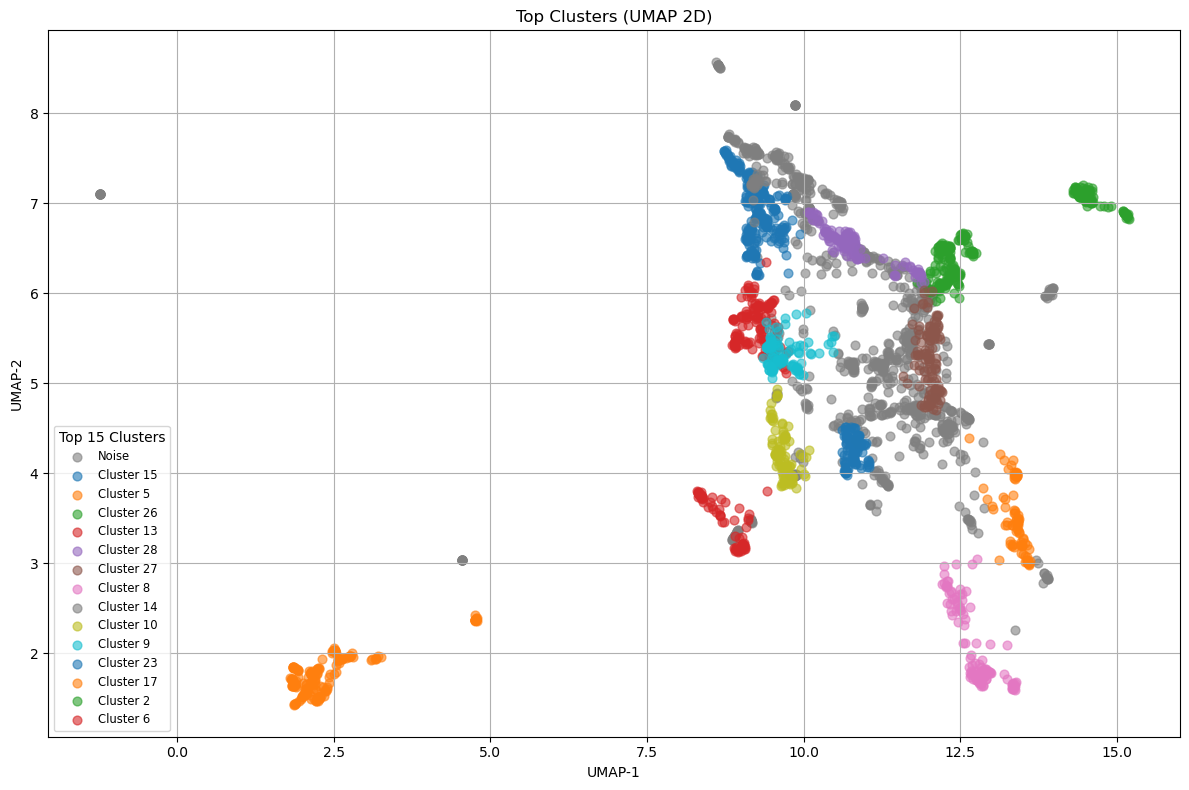

In [61]:
# 2) Gather sentences per cluster
cluster_contents = defaultdict(list)
for lbl, sent in zip(clusterer.labels_, item_list):
    cluster_contents[lbl].append(sent)

# 3) Define a function to pull top-n TF–IDF keywords from a list of docs
def get_cluster_keywords(cluster_sents, top_n=3):
    tfidf   = TfidfVectorizer(stop_words='english', max_features=1000)
    X       = tfidf.fit_transform(cluster_sents)
    mean_tfidf = X.mean(axis=0).A1            # average score per term
    terms       = tfidf.get_feature_names_out()
    top_indices = mean_tfidf.argsort()[::-1][:top_n]
    return [terms[i] for i in top_indices]

# 4) Build your auto‐name map
auto_name_map = {}
for lbl, sents in cluster_contents.items():
    if lbl == -1:
        auto_name_map[lbl] = "Noise / Outliers"
    else:
        kws = get_cluster_keywords(sents, top_n=3)
        auto_name_map[lbl] = " / ".join(kws)

print("Auto‑generated cluster names:")
for lbl, name in auto_name_map.items():
    print(f"  Cluster {lbl:>2} → {name}")

# 5) Inference helper to go from raw sentence → cluster name
def predict_cluster_name(sentence: str):
    emb = model.encode([sentence])
    red = reducer.transform(emb)
    lbl = clusterer.predict(red)[0]
    return auto_name_map.get(lbl, "Unknown")

# 6) Try it
tests = [
    "please send 10 lids only",
    "I need 50 red straws",
    "assemble lid on cup"
]
for t in tests:
    print(f"{t!r}  →  {predict_cluster_name(t)}")

Auto‑generated cluster names:
  Cluster -1 → Noise / Outliers
  Cluster 15 → polybag / poly / bag
  Cluster 14 → barcode / apply / item
  Cluster 13 → label / carton / special
  Cluster 20 → bag / color / package
  Cluster 27 → box / pieces / package
  Cluster 26 → 25 / package / pack
  Cluster 12 → hologram / bag / outside
  Cluster  7 → pouch / insert / cloth
  Cluster  5 → 71 / pink / yellow
  Cluster  4 → lids / ship / straws
  Cluster 24 → box / items / ship
  Cluster 25 → bag / package / special
  Cluster 16 → label / box / package
  Cluster 18 → label / poly / bag
  Cluster  8 → card / insert / special
  Cluster  6 → slip / packing / outside
  Cluster  1 → label / canadian / ingredient
  Cluster 21 → packaging / import / package
  Cluster 23 → pieces / inspect / returned
  Cluster 11 → sticker / add / upc
  Cluster  2 → card / insert / instruction
  Cluster 19 → bag / pcs / special
  Cluster  9 → reship / split / splits
  Cluster 10 → wrap / bubble / piece
  Cluster 22 → ship / 

AttributeError: 'HDBSCAN' object has no attribute 'predict'